<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_tech_support_NB_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔧 Initializing components...
✅ SpaCy, Faker, and stemmer ready.
📦 Generating 10,000 noisy support tickets...
✅ Dataset created.
🔠 Vectorizing text using CountVectorizer + custom tokenizer...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ Vectorization complete. Feature matrix shape: (10000, 779)
📚 Splitting data: 80% train, 20% test...
✅ Split complete.
🧠 Training Naive Bayes model...
✅ Model trained.
🔁 Running cross-validation...

📈 Cross-Validation Scores: [1. 1. 1. 1. 1.]
📊 Mean CV Accuracy: 1.0

🔍 Predicting test set...
✅ Prediction complete.

🧾 Evaluation on Test Set:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0

📊 Confusion Matrix:


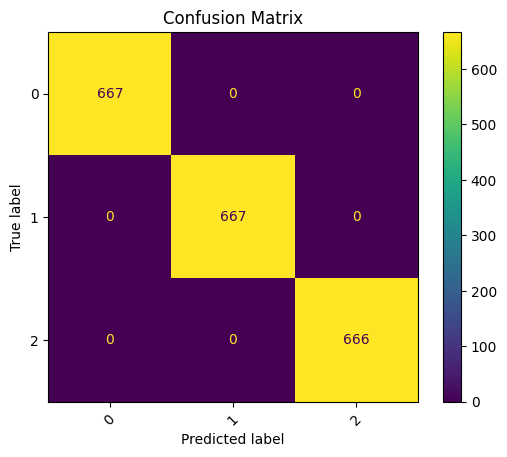


📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       667
           1       1.00      1.00      1.00       667
           2       1.00      1.00      1.00       666

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


🔎 Top predictive words per class:

Top words for class '0':
  charg           -> log-prob: -3.6350
  batteri         -> log-prob: -3.6642
  hard            -> log-prob: -3.6748
  drive           -> log-prob: -3.6813
  issu            -> log-prob: -3.6899
  monitor         -> log-prob: -3.7096
  flicker         -> log-prob: -3.7096
  failur          -> log-prob: -3.7141
  overheat        -> log-prob: -3.7230
  turn            -> log-prob: -3.7457

Top words for class '1':
  network         -> log-prob: -3.7153
  unplug          -> log-prob: -3.7411
  cabl            -> log-prob: -3.7411

In [3]:
!pip install faker

import pandas as pd
import numpy as np
import random
from faker import Faker
import spacy
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt

# Setup
print("🔧 Initializing components...")
fake = Faker()
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()
random.seed(42)
print("✅ SpaCy, Faker, and stemmer ready.")

# Class labels
categories = ["Network", "Software", "Hardware"]

# Generate synthetic support tickets
def generate_ticket(label):
    net_issues = [
        "WiFi not connecting", "VPN drops randomly", "Cannot access intranet",
        "IP conflict detected", "LAN cable unplugged", "Slow network speed"
    ]
    soft_issues = [
        "App crashing on launch", "Unable to login", "Software update failed",
        "Error message on screen", "Can't save document", "License expired"
    ]
    hard_issues = [
        "Monitor flickering", "Laptop won't turn on", "Mouse not responding",
        "Overheating issue", "Hard drive failure", "Battery not charging"
    ]
    noise = fake.sentence()

    if label == "Network":
        msg = f"{random.choice(net_issues)}. {noise}"
    elif label == "Software":
        msg = f"{random.choice(soft_issues)}. {noise}"
    else:
        msg = f"{random.choice(hard_issues)}. {noise}"
    return msg

print("📦 Generating 10,000 noisy support tickets...")
comments = []
labels = []
for _ in range(3333):
    comments.append(generate_ticket("Network"))
    labels.append("Network")
for _ in range(3333):
    comments.append(generate_ticket("Software"))
    labels.append("Software")
for _ in range(3334):
    comments.append(generate_ticket("Hardware"))
    labels.append("Hardware")

df = pd.DataFrame({"Comment": comments, "Topic": labels})
print("✅ Dataset created.")

# Tokenizer
def spacy_tokenizer(sentence):
    doc = nlp(str(sentence))
    return [stemmer.stem(token.lemma_.lower().strip()) for token in doc if not token.is_stop and token.is_alpha]

# Vectorize
print("🔠 Vectorizing text using CountVectorizer + custom tokenizer...")
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1))
X = vectorizer.fit_transform(df['Comment'])
y = df['Topic'].astype('category').cat.codes
print(f"✅ Vectorization complete. Feature matrix shape: {X.shape}")

# Train-test split
print("📚 Splitting data: 80% train, 20% test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("✅ Split complete.")

# Train model
print("🧠 Training Naive Bayes model...")
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("✅ Model trained.")

# Cross-validation
print("🔁 Running cross-validation...")
cv_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy')
print("\n📈 Cross-Validation Scores:", cv_scores)
print("📊 Mean CV Accuracy:", round(np.mean(cv_scores), 4))

# Predict
print("\n🔍 Predicting test set...")
preds = clf.predict(X_test)
print("✅ Prediction complete.")

# Evaluate
print("\n🧾 Evaluation on Test Set:")
print("Precision:", round(precision_score(y_test, preds, average='weighted'), 4))
print("Recall:", round(recall_score(y_test, preds, average='weighted'), 4))
print("F1 Score:", round(f1_score(y_test, preds, average='weighted'), 4))
print("Accuracy:", round(accuracy_score(y_test, preds), 4))

# Confusion matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Classification report
print("\n📋 Classification Report:")
target_names = [str(cls) for cls in clf.classes_]
print(classification_report(y_test, preds, target_names=target_names))

# Top predictive words per class
print("\n🔎 Top predictive words per class:")
feature_names = vectorizer.get_feature_names_out()
for i, class_label in enumerate(clf.classes_):
    top10 = np.argsort(clf.feature_log_prob_[i])[-10:]
    print(f"\nTop words for class '{class_label}':")
    for j in top10[::-1]:
        print(f"  {feature_names[j]:<15} -> log-prob: {clf.feature_log_prob_[i][j]:.4f}")
